# pytorch手把手實作: 物件偵測模型YOLOv3實作 - 以TrafficSign為例
<br>
<font size=4> 
資料集: [kaggle的Road Sign Detection](https://www.kaggle.com/andrewmvd/road-sign-detection) <br>
<br>


## 事前準備
<font size=4>
1. Import會用到的模組。<br>
2. 讀取TrafficSign的資料和parse標註XML，並且擺成YOLO要讀的格式。<br>
3. 畫圖的函數也先宣告。<br>

In [1]:
import warnings
warnings.simplefilter("ignore")
import os
import random
import math
from datetime import datetime
from collections import Counter
import numpy as np
import cv2
from PIL import Image
from pathlib import Path
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

# labelmap = {'background':0, 'trafficlight': 1, 'speedlimit': 2, 'crosswalk': 3, 'stop': 4}
labelmap = {'trafficlight': 0, 'speedlimit': 1, 'crosswalk': 2, 'stop': 3}
images_path = Path('./dataset/stopsign/images')
anno_path = Path('./dataset/stopsign/annotations')
def filelist(root, file_type):
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]
def xml_parser_yolo(xml_path):
    root = ET.parse(xml_path).getroot()
    filename = Path(str(images_path) + '/' + root.find("./filename").text)
    bboxes=[]
    labels=[]
    for object_xml in root.iter('object'):
        label = object_xml.find('name').text.lower()
        bbox = object_xml.find('bndbox')
        xmin = int(bbox.find("xmin").text) 
        ymin = int(bbox.find("ymin").text) 
        xmax = int(bbox.find("xmax").text) 
        ymax = int(bbox.find("ymax").text) 
        x = int((xmin+xmax)/2)
        y = int((ymin+ymax)/2)
        w = int(xmax-xmin)
        h = int(ymax-ymin)
        bbox = [labelmap[label], x, y, w, h]
        bboxes.append(bbox)
    return filename, bboxes

def generate_data_inf(annotations):
    imagepaths = []
    bboxes = []
    for anno_path in annotations:
        filename, bboxs = xml_parser_yolo(anno_path)
        imagepaths.append(filename)
        bboxes.append(bboxs)
    return imagepaths, bboxes

def xywh2box(box):
    # x -> w, y -> h
    x,y,w,h = box
    x_min = int(x - w/2)
    x_max = int(x + w/2)
    y_min = int(y - h/2)
    y_max = int(y + h/2)
    return [x_min, y_min, x_max, y_max]    
def plot_image_xywhbbox(img, bboxs, flag_bgr=1):
    imageplot=img.copy()
    for bb in bboxs:
        label = bb[0]
        bb = bb[1:]
        bb = xywh2box(bb)
        cv2.rectangle(imageplot,(int(bb[0]),int(bb[1])),(int(bb[2]),int(bb[3])),(0,255,0),2)
        cv2.putText(imageplot, str(label), (int(bb[0]),int(bb[1])), 0, 1, (200, 0, 255), 4, cv2.LINE_AA)
    if flag_bgr==1:
        plt.imshow(cv2.cvtColor(imageplot, cv2.COLOR_BGR2RGB))
    else:
         plt.imshow(imageplot)
    plt.show()
    
annotations = filelist(anno_path, '.xml')
imagepaths, bboxes = generate_data_inf(annotations)

### 將資料分成Train Set和Test Set</font>


In [2]:
n_data = len(imagepaths)
val_size = 0.2
n_val = int(n_data * val_size)
n_train = n_data - n_val
np.random.seed(20210626)
randorder = np.random.permutation(n_data)

data_train = [imagepaths[randorder[tmp]]for tmp in range(n_train)]
bboxes_train = [bboxes[randorder[tmp]]for tmp in range(n_train)]
data_val = [imagepaths[randorder[tmp]]for tmp in range(n_train, n_data)]
bboxes_val = [bboxes[randorder[tmp]]for tmp in range(n_train, n_data)]
print('number of training data:{}'.format(len(data_train)))
print('number of validation data:{}'.format(len(data_val)))
print('number of total data:{}'.format(n_data))

number of training data:702
number of validation data:175
number of total data:877


### Pytorch去兜一個YOLOv2架構(Darknet-19)，但是是YOLOv3的Multi-scale輸出的模型<br>
<font size=4>
我這邊把模型稱為yolov2_5，因為YOLOv3模型太大，我這邊筆電資源不夠不好訓練<br>
    
所以我based在YOLOv2的Darknet19下去架構一個類似YOLO3的multi-scale輸出(在$\frac{1}{16}$scale和$\frac{1}{32}$scale的特徵圖)<br>
    
這個模型的onnx輸出也有17X MB這麼大。
    
>一般看到YOLO系列的pytorch文章，大多是去parser Darknet的cfg檔案，但那個太麻煩了，還要介紹一堆Darknet運到的元件，跳過...

In [3]:
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
import torch

def autopad(k, p=None):  # kernel, padding
    # Pad to 'same'
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return p

class CBRk(nn.Module):
    # Standard convolution
    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, act=True):  # ch_in, ch_out, kernel, stride, padding, groups
        super(CBRk, self).__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, autopad(k, p), groups=g, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = nn.LeakyReLU(0.1) if act is True else (act if isinstance(act, nn.Module) else nn.Identity())
    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

    def fuseforward(self, x):
        return self.act(self.conv(x))
    
class ReOrgLayer(nn.Module):
    def __init__(self, stride = 2):
        super(ReOrgLayer, self).__init__()
        self.stride= stride
        
    def forward(self,x):
        assert(x.data.dim() == 4)
        B,C,H,W = x.data.shape
        hs = self.stride
        ws = self.stride
        assert(H % hs == 0),  "The stride " + str(self.stride) + " is not a proper divisor of height " + str(H)
        assert(W % ws == 0),  "The stride " + str(self.stride) + " is not a proper divisor of height " + str(W)
        x = x.view(B,C, H // hs, hs, W // ws, ws).transpose(-2,-3).contiguous()
        x = x.view(B,C, H // hs * W // ws, hs, ws)
        x = x.view(B,C, H // hs * W // ws, hs*ws).transpose(-1,-2).contiguous()
        x = x.view(B, C, ws*hs, H // ws, W // ws).transpose(1,2).contiguous()
        x = x.view(B, C*ws*hs, H // ws, W // ws)
        return x
    
    
class yolov2_5(nn.Module):
    # input image size = 224*224
    def __init__(self, n_class, n_bbox):
        super(yolov2_5, self).__init__()
        
        n_ch_out = (n_class+5)*n_bbox
        self.conv1 = nn.Sequential(CBRk(3,32,3,1),
                                   nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv2 = nn.Sequential(CBRk(32,64,3,1),
                                   nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.conv3 = nn.Sequential(CBRk(64,128,3,1),
                                   CBRk(128,64,1,1),
                                   CBRk(64,128,3,1),                                   
                                   nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.conv4 = nn.Sequential(CBRk(128,256,3,1),
                                   CBRk(256,128,1,1),
                                   CBRk(128,256,3,1),                                   
                                   nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.conv5 = nn.Sequential(CBRk(256,512,3,1),
                                   CBRk(512,256,1,1),
                                   CBRk(256,512,3,1),
                                   CBRk(512,256,1,1),
                                   CBRk(256,512,3,1))
        self.conv5_maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.detection16s_1 = CBRk(512,512,3,1)
        self.detection16s_2 = nn.Conv2d(512, n_ch_out, 1, bias=True)

        
        self.conv6 = nn.Sequential(CBRk(512,1024,3,1),
                                   CBRk(1024,512,1,1),
                                   CBRk(512,1024,3,1),
                                   CBRk(1024,512,1,1),
                                   CBRk(512,1024,3,1))
        
        self.conv7 = nn.Sequential(CBRk(1024,1024,3,1),
                                   CBRk(1024,1024,1,1))
        

        
        self.branch_aftconv5 =CBRk(512,64,1,1)
        self.bbranch_reorg = ReOrgLayer() # 64*4=256
        
        self.conv8 = CBRk(1024+256,1024,3,1)
        self.detection32s = nn.Conv2d(1024, n_ch_out, 1, bias=True)
        
    def forward(self, x):
        # b * 3 * 224 * 224
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        out_16s = self.detection16s_1(x)
        out_16s = self.detection16s_2(out_16s)
        
        
        shortcut = x
        x = self.conv5_maxpool(x)
        
        
        
        x = self.conv6(x)
        x = self.conv7(x)
        
        x_branch = self.branch_aftconv5(shortcut)
        x_branch = self.bbranch_reorg(x_branch)
        
        x = torch.cat([x,x_branch],dim=1)
        
        x = self.conv8(x)
        out_32s = self.detection32s(x)
        return out_16s,out_32s
    
model = yolov2_5(n_class=20, n_bbox=3)
dummy_inpurt = torch.rand(1,3,416,416)
out=model(dummy_inpurt)
torch.onnx.export(model, dummy_inpurt, './yolov2_5.onnx', opset_version=11, example_outputs=out)

### DataLoader定義、影像前處理和Data Augmentation


In [4]:
from torch.utils.data import Dataset, DataLoader
def resizewithbbox(image, bboxes, newsize=[224,224]):
    # bboxes: [label, x,y,w,h]
    image = np.array(image)
    h,w,ch = image.shape
    new_w, new_h = newsize[0], newsize[1]
    scale_h, scale_w = new_h/h, new_w/w
    new_image = cv2.resize(image, (new_w, new_h))
    new_image = Image.fromarray(new_image)
    n = len(bboxes)
    new_bboxes = np.array(bboxes)
    if n:
        new_bboxes[:, 1] = new_bboxes[:, 1]*scale_w 
        new_bboxes[:, 2] = new_bboxes[:, 2]*scale_h 
        new_bboxes[:, 3] = new_bboxes[:, 3]*scale_w 
        new_bboxes[:, 4] = new_bboxes[:, 4]*scale_h 
    return new_image, new_bboxes    
from torchvision import transforms
# image pre-process
process_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ]
)
transforms_dataaug = transforms.ColorJitter(brightness=(0.5, 1.5), 
                                            contrast=(0.5, 1.5), 
                                            saturation=(0.5, 1.5), 
                                            hue=(-18/255, 18/255))

# imagepaths, annos, class_dict
class TrafficSignDataset(Dataset):
    def __init__(self, image_paths, bboxes, newsize=[224.0,224.0], is_transforms=False):
        self.is_transforms = is_transforms
        self.image_paths = image_paths
        self.bboxes = bboxes
        self.newsize=newsize
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        path = self.image_paths[idx]
        bboxes = self.bboxes[idx]
        
        # 1.
        img = Image.open(path, mode='r')
        img = img.convert('RGB')
                
        # 2.
        img, bboxes = resizewithbbox(img, bboxes,newsize=self.newsize)
        
        # 3.
        if self.is_transforms:
            if np.random.random()<0.3:
                img = transforms_dataaug(img)
        img = process_transforms(img)
        
        bboxes= np.array(bboxes,dtype=np.float32)
        bboxes[:,1:]=bboxes[:,1:]/self.newsize[0]
        bboxes= torch.FloatTensor(bboxes)
        return img, bboxes
     
    def collate_fn(self, batch):
        imgs = list()
        bboxes = list()
        for b in batch:
            imgs.append(b[0])
            bboxes.append(b[1])
        imgs=torch.stack(imgs,dim=0)
        return imgs, bboxes
  

<font size=4>
IoU請看17_IoU-PytorchNumpy.ipynb的介紹。

In [5]:
import torch
def bbox_iou(box1, box2, x1y1x2y2=True):
    if not x1y1x2y2:
        b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
        b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
        b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
        b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
    else:
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    # area of overlap
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(
        inter_rect_y2 - inter_rect_y1 + 1, min=0
    )
    # box1 area and box2 area.
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)
    # IoU    
    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)
    return iou

<font size=4>
    
以下我有用到部分fuunction是節錄至 [網路github.io的文章](https://hellozhaozheng.github.io/z_post/PyTorch-YOLO/) <br>
1. build_targets
2. YOLOLayer: 內含YOLO loss
    
Note: 但其函數有一些小錯誤，我有進行修改
    


In [6]:
def build_targets(
    pred_boxes, pred_conf, pred_cls, target, anchors, num_anchors, num_classes, grid_size, ignore_thres, img_dim
):
    # 参数:
    # pred_boxes: [1, 3, 13, 13, 4]
    # pred_conf: [1, 3, 13, 13]
    # pred_cls: [1, 3, 13, 13, 80]
    # target: [1, n_object_b, 5]
    # anchors: [3, 2]
    # num_anchors: 3
    # num_classes: 80
    # grid_size: 13(特征图谱的尺寸)
    # ignore_thres: 0.5
    # img_dim: 图片尺寸
    nB = pred_boxes.size(0) # batch_size
    nA = num_anchors # 3
    nC = num_classes # 80
    nG = grid_size # 特征图谱的尺寸(eg: 13)
    mask = torch.zeros(nB, nA, nG, nG) # eg: [1, 3, 13, 13], 代表每个特征图谱上的 anchors 下标(每个 location 都有 3 个 anchors)
    conf_mask = torch.ones(nB, nA, nG, nG) # eg: [1, 3, 13, 13] 代表每个 anchor 的置信度.
    tx = torch.zeros(nB, nA, nG, nG) # 申请占位空间, 存放每个 anchor 的中心坐标
    ty = torch.zeros(nB, nA, nG, nG) # 申请占位空间, 存放每个 anchor 的中心坐标
    tw = torch.zeros(nB, nA, nG, nG) # 申请占位空间, 存放每个 anchor 的宽
    th = torch.zeros(nB, nA, nG, nG) # 申请占位空间, 存放每个 anchor 的高
    tconf = torch.ByteTensor(nB, nA, nG, nG).fill_(0) # 占位空间, 存放置信度, eg: [1, 3, 13, 13]
    tcls = torch.ByteTensor(nB, nA, nG, nG, nC).fill_(0) # 占位空间, 存放分类预测值, eg:[1, 3, 13, 13, 80]

    nGT = 0
    nCorrect = 0
    for b in range(nB):
        sub_target = target[b] # n_objects * 5
        n_object = sub_target.shape[0]
        if n_object==0:
            continue

        for t in range(n_object):
            nGT += 1 # 每找到一个非零的 box, 则真实box的数量就加一

            # Convert to position relative to box
            # 由于我们在存储box的坐标时, 就是按照其相对于图片的宽和高的比例存储的
            # 因此, 当想要获取特征图谱上的对应 box 的坐标时, 直接令其与特征图谱的尺寸相乘即可.
            gx = sub_target[t, 1] * nG
            gy = sub_target[t, 2] * nG
            gw = sub_target[t, 3] * nG 
            gh = sub_target[t, 4] * nG 


            # Get grid box indices
            # 获取在特征图谱上的整数坐标
            gi = int(gx)
            gj = int(gy)
            if gi<0:gi=0
            if gj<0:gj=0
            if gi>=nG: gi=nG-1
            if gj>=nG: gj=nG-1

            # Get shape of gt box, 根据 box 的大小获取 shape: [1,4]
            gt_box = torch.FloatTensor(np.array([0, 0, gw, gh])).unsqueeze(0)

            # Get shape of anchor box
            # 相似的方法得到anchor的shape: [3, 4] , 3 代表3个anchor
            anchor_shapes = torch.FloatTensor(np.concatenate((np.zeros((len(anchors), 2)), np.array(anchors)), 1))


            # 调用本文件的 bbox_iou 函数计算gt_box和anchors之间的交并比
            # 注意这里仅仅计算的是 shape 的交并比, 此处没有考虑位置关系.
            # gt_box 为 [1,4], anchors 为 [3, 4],
            # 最终返回的值为[3], 代表了 gt_box 与每个 anchor 的交并比大小
            anch_ious = bbox_iou(gt_box, anchor_shapes)

            # 将交并比大于阈值的部分设置conf_mask的对应位为0(ignore)
            
            pos = anch_ious > ignore_thres
            pos = pos.nonzero() 
            if pos.shape[0]>0:   
                conf_mask[b, pos, gj, gi] = 0

            # 找到匹配度最高的 anchor box, 返回下标: 0,1,2 中的一个
            best_n = np.argmax(anch_ious)

            # 获取相应的 ground truth box, unsqueeze用于扩充维度, 使[4]变成[1,4], 以便后面的计算
            gt_box = torch.FloatTensor(np.array([gx, gy, gw, gh])).unsqueeze(0)

            # 获取最佳的预测 box, pred_boxes的shape为: [1,3,13,13,4]
            # pred_box经过unsqueeze扩充后的shape为: [1,4]

            pred_box = pred_boxes[b, best_n, gj, gi, :].unsqueeze(0)

            # 设置 mask 和 conf_mask
            mask[b, best_n, gj, gi] = 1

            # 注意, 刚刚将所有大于阈值的 conf_mask对应为都设置为了0,
            # 然后这里将具有最大交并比的anchor设置为1, 如此确保一个真实框只对应一个 anchor.
            # 由于 conf_mask 的默认值为1, 因此, 剩余的box可看做是负样本
            conf_mask[b, best_n, gj, gi] = 1

            # 设置中心坐标, 该坐标是相对于 cell的左上角而言的, 所以是一个小于1的数
            tx[b, best_n, gj, gi] = gx - gi
            ty[b, best_n, gj, gi] = gy - gj
            

            # 设置宽和高, 注意, 这里会转化成训练时使用的宽高值
            tw[b, best_n, gj, gi] = math.log(gw / anchors[best_n][0] + 1e-16)
            th[b, best_n, gj, gi] = math.log(gh / anchors[best_n][1] + 1e-16)


            # 获取当前 box 的 标签
            target_label = int(sub_target[t, 0])
            # tcls: [1,3,13,13,80]
            # 将当前true box对应的 anchor 的正确类别设置为1
            tcls[b, best_n, gj, gi, target_label] = 1
            # 将置信度设置为 1
            tconf[b, best_n, gj, gi] = 1

            # 调用 bbox_iou 函数计算 ground truth 和最佳匹配的预测box之间的 iou
            # 注意, 此时的 gt_box为 [gx,gy,gw,gh], 不是 [tx,ty,tw,th]
            # gt_box的shape为[1,4], pred_box为最佳匹配的预测 box, 其shape也为[1,4]
            iou = bbox_iou(gt_box, pred_box, x1y1x2y2=False)
            # pred_cls的shape为[1,3,13,13,80], 获取最佳匹配anchor box的最大概率类别的下标
            pred_label = torch.argmax(pred_cls[b, best_n, gj, gi])
            # pred_conf的shape为[1,3,13,13], 获取最佳匹配anchor box的置信度
            score = pred_conf[b, best_n, gj, gi]
            if iou > 0.5 and pred_label == target_label and score > 0.5:
                nCorrect += 1 # 如果 iou 和 score 大于阈值, 并且标签预测正确, 则正确项增1
    # 将所有需要的信息都返回, 从这里可以看出, 每一个 YOLO 层都会执行一次预测.
    return nGT, nCorrect, mask, conf_mask, tx, ty, tw, th, tconf, tcls

class YOLOLayer(nn.Module):
    def __init__(self, anchors, num_classes, img_dim):
        super(YOLOLayer, self).__init__()
        self.anchors = anchors # anchors = [(116,90),(156,198),(373,326)]
        self.num_anchors = len(anchors) # 3
        self.num_classes = num_classes # 4
        self.bbox_attrs = 5 + num_classes #
        self.image_dim = img_dim # 224
        self.ignore_thres = 0.5
        self.lambda_coord = 2
        self.lambda_noObjectConfidence = 1

        self.mse_loss = nn.MSELoss(size_average=True)
        self.bce_loss = nn.BCELoss(size_average=True)
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, x, targets=None):
        # x: [nB, n_anchors*(5+num_classes), 7, 7]
        # targets: [n_object, 5 ], 5: label, x, y, w, h
        nA = self.num_anchors # 3
        nB = x.size(0) # batch_size
        nG = x.size(2) # W = 7
        stride = self.image_dim / nG # 224 / W = 224 / 7 = 32
        FloatTensor = torch.cuda.FloatTensor if x.is_cuda else torch.FloatTensor
        LongTensor = torch.cuda.LongTensor if x.is_cuda else torch.LongTensor
        ByteTensor = torch.cuda.ByteTensor if x.is_cuda else torch.ByteTensor
        
        # view: (batch, anchors, 5+num_classes, nG, nG): # [1, 3, 9, 7, 7] 
        # 调换顺序: batch, anchors, nG, nG, 5+num_classes:# [1,3, 7, 7, 9] 
        prediction = x.view(nB, nA, self.bbox_attrs, nG, nG).permute(0,1,3,4,2).contiguous()

        x = torch.sigmoid(prediction[..., 0]) # center x: [1, 3, 7, 7]
        y = torch.sigmoid(prediction[..., 1]) # center y: [1, 3, 7, 7]
        w = prediction[..., 2] # width: [1, 3, 7, 7]
        h = prediction[..., 3] # height: [1, 3, 7, 7]
        pred_conf = torch.sigmoid(prediction[..., 4]) # [1, 3, 7, 7]
        pred_cls = torch.sigmoid(prediction[..., 5:]) # [1, 3, 7, 7, 4]

        # grid_x的shape为[1,1,nG,nG], 每一行的元素为:[0,1,2,3,...,nG-1]
        grid_x = torch.arange(nG).repeat(nG, 1).view([1,1,nG,nG]).type(FloatTensor)
        # grid_y的shape为[1,1,nG,nG], 每一列元素为: [0,1,2,3, ...,nG-1]
        grid_y = torch.arange(nG).repeat(nG, 1).t().view(1,1,nG,nG).type(FloatTensor)

        # scaled_anchors 是将原图上的 box 大小根据当前fearture map的大小转换成相应的feature map上的 box
        # shape: [3, 2]
        scaled_anchors = FloatTensor([(a_w / stride, a_h / stride) for a_w, a_h in self.anchors])
        
        
        # 分别获取其 w 和 h, 并将shape形状变为: [1,3,1,1]
        anchor_w = scaled_anchors[:, 0:1].view((1, nA, 1, 1))
        anchor_h = scaled_anchors[:, 1:2].view((1, nA, 1, 1))

        # shape: [1, 3, 13, 13, 4], 给 anchors 添加 offset 和 scale
        pred_boxes = FloatTensor(prediction[..., :4].shape)
        pred_boxes[..., 0] = x.data + grid_x
        pred_boxes[..., 1] = y.data + grid_y
        pred_boxes[..., 2] = torch.exp(w.data) * anchor_w
        pred_boxes[..., 3] = torch.exp(h.data) * anchor_h
                
        if targets is not None:# 如果提供了 targets 标签, 则说明是处于训练阶段

            if x.is_cuda:
                self.mse_loss = self.mse_loss.cuda()
                self.bce_loss = self.bce_loss.cuda()
                self.ce_loss = self.ce_loss.cuda()

            # 调用 utils.py 文件中的 build_targets 函数, 将真实的 box 数据转化成训练用的数据格式
            # nGT = int 真实box的数量
            # nCorrect = int 预测正确的数量
            # mask: torch.Size([1, 3, 13, 13])
            # conf_mask: torch.Size([1, 3, 13, 13])
            # tx: torch.Size([1, 3, 13, 13])
            # ty: torch.Size([1, 3, 13, 13])
            # tw: torch.Size([1, 3, 13, 13])
            # th: torch.Size([1, 3, 13, 13])
            # tconf: torch.Size([1, 3, 13, 13])
            # tcls: torch.Size([1, 3, 13, 13, 80])
            targets = [target.cpu().data for target in targets]
            nGT, nCorrect, mask, conf_mask, tx, ty, tw, th, tconf, tcls = build_targets(
                pred_boxes = pred_boxes.cpu().data,
                pred_conf = pred_conf.cpu().data,
                pred_cls = pred_cls.cpu().data,
                target = targets,
                anchors = scaled_anchors.cpu().data,
                num_anchors = nA,
                num_classes = self.num_classes,
                grid_size = nG,
                ignore_thres = self.ignore_thres,
                img_dim = self.image_dim,
            )

            
            nProposals = int((pred_conf > 0.5).sum().item()) # 计算置信度大于0.5的预测box数量
            recall = float(nCorrect / nGT) if nGT else 1 # 计算召回率
            precision = float(nCorrect / nProposals)
            
            # 处理 masks
            
            mask = mask.type(ByteTensor)
            conf_mask = conf_mask.type(ByteTensor)
            
            
            # 处理 target Variables
            tx = tx.type(FloatTensor)
            ty = ty.type(FloatTensor)
            tw = tw.type(FloatTensor)
            th = th.type(FloatTensor)
            tconf = tconf.type(FloatTensor)
            tcls = tcls.type(FloatTensor)

            # 获取表明gt和非gt的conf_mask
            # 这里 conf_mask_true 指的是具有最佳匹配度的anchor box
            # conf_mask_false 指的是iou小于0.5的anchor box, 其余的anchor box都被忽略了
            conf_mask_true = mask # mask 只有best_n对应位为1, 其余都为0
            conf_mask_false = conf_mask-mask # conf_mask中iou大于ignore_thres的为0, 其余为1, best_n也为1

             
            # 忽略 non-existing objects, 计算相应的loss
            
            loss_x = self.mse_loss(x[mask], tx[mask])
            loss_y = self.mse_loss(y[mask], ty[mask])
            loss_w = self.mse_loss(w[mask], tw[mask])
            loss_h = self.mse_loss(h[mask], th[mask])
            
            
            # 这里 conf_mask_true 指的是具有最佳匹配度的anchor box
            # conf_mask_false 指的是iou小于0.5的anchor box, 其余的anchor box都被忽略了
            loss_conf =  self.lambda_noObjectConfidence * self.bce_loss(
                pred_conf[conf_mask_false], tconf[conf_mask_false]
            ) + self.bce_loss(
                pred_conf[conf_mask_true], tconf[conf_mask_true]
            )

            # pred_cls[mask]的shape为: [7,80], torch.argmax(tcls[mask], 1)的shape为[7]
            # CrossEntropyLoss对象的输入为(x,class), 其中x为预测的每个类的概率, class为gt的类别下标
            loss_cls =  self.ce_loss(pred_cls[mask], torch.argmax(tcls[mask], 1))

            loss = self.lambda_coord*(loss_x + loss_y + loss_w + loss_h) + 2*loss_conf + loss_cls

            return (
                loss,
                loss_x.item(),
                loss_y.item(),
                loss_w.item(),
                loss_h.item(),
                loss_conf.item(),
                loss_cls.item(),
                recall,
                precision,
            )
        else:
            return pred_boxes.view(nB, -1, 4) * stride, pred_conf.view(nB, -1, 1) , pred_cls.view(nB, -1, self.num_classes)

### 相關hyperparameter、dataloader、optimizer宣告

In [7]:
torch.cuda.empty_cache()
use_cuda = 1
device = torch.device("cuda:0" if use_cuda else "cpu")
total_epochs = 100
n_class = 4
n_bbox = 3
lr = 0.0002
batch_size = 16
img_dim = 224
anchors_16s =[[10,13],  [30,61],  [62,45]]
anchors_32s =[[50,100], [150,150],[200,200]]

dataset_train = TrafficSignDataset( data_train, bboxes_train, newsize=[224,224], is_transforms=True) 
train_dl = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=dataset_train.collate_fn )
dataset_val = TrafficSignDataset( data_val, bboxes_val, newsize=[224,224], is_transforms=True) 
val_dl = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, collate_fn=dataset_val.collate_fn )

model = yolov2_5(n_class=n_class, n_bbox=n_bbox).to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=lr)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


yololayer16s = YOLOLayer(anchors_16s, num_classes=n_class, img_dim=img_dim)
yololayer32s = YOLOLayer(anchors_32s, num_classes=n_class, img_dim=img_dim)


### 模型訓練

In [8]:
from collections import defaultdict
def fun_printlog(batch_i, dataloader, loss16s, loss32s, loss, frequency_printlog):
    loss_names = ["total_loss", "x", "y", "w", "h", "conf", "cls", "recall", "precision"]
    
    if batch_i % frequency_printlog ==0:
        losses = defaultdict(float)
        for lossms in [loss16s, loss32s]:
            for name, tmp_loss in zip(loss_names, lossms): #将losses根据名字加入字典
                losses[name] += tmp_loss
        for name, tmp in zip(loss_names, loss32s): #将losses根据名字加入字典
            losses[name] /=   2

        print(
                "[Epoch %d/%d, Batch %d/%d]: \n\tLosses: total %.3f, x %.3f, y %.3f, w %.3f, h %.3f, conf %.3f, cls %.3f, recall: %.3f, precision: %.3f"
                % (
                    epoch+1,
                    total_epochs,
                    batch_i,
                    len(dataloader),
                    loss.item(),
                    losses["x"],
                    losses["y"],
                    losses["w"],
                    losses["h"],
                    losses["conf"],
                    losses["cls"],
                    losses["recall"],
                    losses["precision"],
                )
            )

    
def step_train(model, train_dl):
    model.train()
    sum_loss = 0
    for batch_i, (imgs, bboxs) in enumerate(train_dl):
        len_batch = imgs.shape[0]
        imgs = imgs.to(device)
        bboxs = [b.to(device) for b in bboxs]
        out_16s, out_32s = model(imgs)

        loss16s = yololayer16s(out_16s,bboxs)
        loss32s = yololayer32s(out_32s,bboxs)
        
        loss = (loss16s[0]+loss32s[0])/2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        sum_loss+=loss.item()
        fun_printlog(batch_i,train_dl, loss16s,loss32s,loss,frequency_printlog=100)
    scheduler.step()
    return sum_loss/len(train_dl)

def step_val(model, train_dl):
    model.eval()
    sum_loss = 0
    for batch_i, (imgs, bboxs) in enumerate(val_dl):
        len_batch = imgs.shape[0]
        imgs = imgs.to(device)
        bboxs = [b.to(device) for b in bboxs]
        with torch.no_grad():
            out_16s, out_32s = model(imgs)
        
        loss16s = yololayer16s(out_16s,bboxs)
        loss32s = yololayer32s(out_32s,bboxs)
        
        loss = (loss16s[0]+loss32s[0])/2
        
        sum_loss+=loss.item()
        fun_printlog(batch_i,val_dl, loss16s,loss32s,loss, frequency_printlog=100)
    return sum_loss/len(val_dl)

loss_train,loss_val=[],[]
for epoch in range(total_epochs):
    print('*'*50)
    print('Train...')
    loss_train.append(step_train(model, train_dl))
    print('Val...')
    loss_val.append(step_val(model, train_dl))
    
        
    torch.save(model,'yolov2_5.pth')      

**************************************************
Train...
[Epoch 1/100, Batch 0/44]: 
	Losses: total 9.063, x 0.073, y 0.128, w 1.010, h 1.249, conf 1.388, cls 1.366, recall: 0.040, precision: 0.000
Val...
[Epoch 1/100, Batch 0/11]: 
	Losses: total 4.459, x 0.071, y 0.079, w 0.267, h 0.463, conf 0.712, cls 1.274, recall: 0.145, precision: 0.005
**************************************************
Train...
[Epoch 2/100, Batch 0/44]: 
	Losses: total 3.308, x 0.063, y 0.096, w 0.091, h 0.175, conf 0.681, cls 1.096, recall: 0.579, precision: 0.016
Val...
[Epoch 2/100, Batch 0/11]: 
	Losses: total 3.943, x 0.063, y 0.086, w 0.255, h 0.325, conf 0.617, cls 1.251, recall: 0.258, precision: 0.016
**************************************************
Train...
[Epoch 3/100, Batch 0/44]: 
	Losses: total 2.845, x 0.057, y 0.080, w 0.087, h 0.148, conf 0.559, cls 0.982, recall: 0.750, precision: 0.028
Val...
[Epoch 3/100, Batch 0/11]: 
	Losses: total 3.450, x 0.061, y 0.083, w 0.159, h 0.205, conf 0.5

Val...
[Epoch 24/100, Batch 0/11]: 
	Losses: total 2.961, x 0.048, y 0.038, w 0.059, h 0.115, conf 0.679, cls 1.083, recall: 0.419, precision: 0.168
**************************************************
Train...
[Epoch 25/100, Batch 0/44]: 
	Losses: total 1.107, x 0.006, y 0.008, w 0.007, h 0.019, conf 0.064, cls 0.896, recall: 0.900, precision: 0.286
Val...
[Epoch 25/100, Batch 0/11]: 
	Losses: total 2.968, x 0.051, y 0.039, w 0.071, h 0.111, conf 0.671, cls 1.082, recall: 0.452, precision: 0.200
**************************************************
Train...
[Epoch 26/100, Batch 0/44]: 
	Losses: total 0.982, x 0.005, y 0.009, w 0.008, h 0.008, conf 0.048, cls 0.827, recall: 0.891, precision: 0.289
Val...
[Epoch 26/100, Batch 0/11]: 
	Losses: total 3.254, x 0.046, y 0.035, w 0.077, h 0.114, conf 0.823, cls 1.064, recall: 0.516, precision: 0.232
**************************************************
Train...
[Epoch 27/100, Batch 0/44]: 
	Losses: total 0.996, x 0.006, y 0.007, w 0.009, h 0.013, co

**************************************************
Train...
[Epoch 48/100, Batch 0/44]: 
	Losses: total 0.935, x 0.008, y 0.006, w 0.004, h 0.005, conf 0.028, cls 0.833, recall: 0.912, precision: 0.414
Val...
[Epoch 48/100, Batch 0/11]: 
	Losses: total 3.333, x 0.051, y 0.032, w 0.065, h 0.109, conf 0.912, cls 0.996, recall: 0.565, precision: 0.378
**************************************************
Train...
[Epoch 49/100, Batch 0/44]: 
	Losses: total 0.944, x 0.004, y 0.006, w 0.007, h 0.006, conf 0.050, cls 0.801, recall: 0.885, precision: 0.477
Val...
[Epoch 49/100, Batch 0/11]: 
	Losses: total 3.336, x 0.049, y 0.032, w 0.062, h 0.107, conf 0.918, cls 0.999, recall: 0.548, precision: 0.350
**************************************************
Train...
[Epoch 50/100, Batch 0/44]: 
	Losses: total 0.920, x 0.002, y 0.002, w 0.005, h 0.004, conf 0.023, cls 0.848, recall: 0.875, precision: 0.411
Val...
[Epoch 50/100, Batch 0/11]: 
	Losses: total 3.505, x 0.045, y 0.032, w 0.073, h 0.113, co

Val...
[Epoch 71/100, Batch 0/11]: 
	Losses: total 3.366, x 0.048, y 0.036, w 0.059, h 0.107, conf 0.938, cls 0.988, recall: 0.516, precision: 0.390
**************************************************
Train...
[Epoch 72/100, Batch 0/44]: 
	Losses: total 0.877, x 0.003, y 0.002, w 0.007, h 0.007, conf 0.023, cls 0.795, recall: 0.905, precision: 0.437
Val...
[Epoch 72/100, Batch 0/11]: 
	Losses: total 3.243, x 0.053, y 0.038, w 0.062, h 0.101, conf 0.852, cls 1.033, recall: 0.484, precision: 0.335
**************************************************
Train...
[Epoch 73/100, Batch 0/44]: 
	Losses: total 0.888, x 0.003, y 0.004, w 0.005, h 0.007, conf 0.025, cls 0.798, recall: 0.920, precision: 0.521
Val...
[Epoch 73/100, Batch 0/11]: 
	Losses: total 3.286, x 0.047, y 0.038, w 0.064, h 0.102, conf 0.880, cls 1.025, recall: 0.484, precision: 0.306
**************************************************
Train...
[Epoch 74/100, Batch 0/44]: 
	Losses: total 0.854, x 0.004, y 0.003, w 0.004, h 0.004, co

**************************************************
Train...
[Epoch 95/100, Batch 0/44]: 
	Losses: total 0.849, x 0.004, y 0.008, w 0.006, h 0.007, conf 0.023, cls 0.754, recall: 0.921, precision: 0.525
Val...
[Epoch 95/100, Batch 0/11]: 
	Losses: total 3.415, x 0.047, y 0.037, w 0.066, h 0.122, conf 0.945, cls 0.979, recall: 0.516, precision: 0.388
**************************************************
Train...
[Epoch 96/100, Batch 0/44]: 
	Losses: total 0.872, x 0.003, y 0.004, w 0.004, h 0.006, conf 0.023, cls 0.793, recall: 0.955, precision: 0.476
Val...
[Epoch 96/100, Batch 0/11]: 
	Losses: total 3.600, x 0.055, y 0.042, w 0.065, h 0.089, conf 1.051, cls 0.996, recall: 0.548, precision: 0.433
**************************************************
Train...
[Epoch 97/100, Batch 0/44]: 
	Losses: total 1.016, x 0.005, y 0.003, w 0.011, h 0.010, conf 0.026, cls 0.906, recall: 0.788, precision: 0.439
Val...
[Epoch 97/100, Batch 0/11]: 
	Losses: total 3.534, x 0.046, y 0.034, w 0.060, h 0.111, co

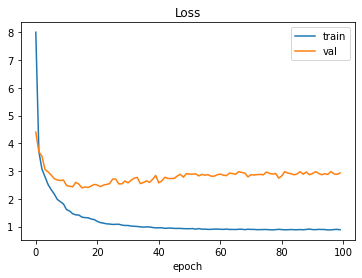

In [9]:
plt.figure()
plt.plot(loss_train)
plt.plot(loss_val)
plt.xlabel('epoch')
plt.legend(['train','val'])
plt.title('Loss')
plt.show()

## 4. 模型測試 (Inference with NMS)

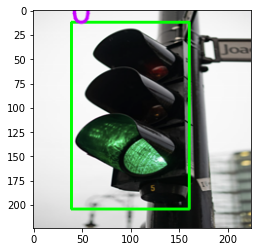

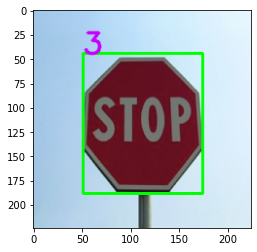

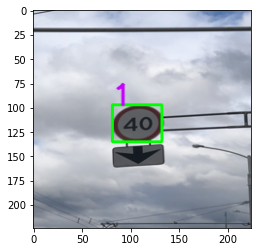

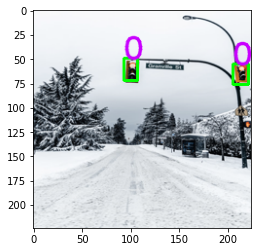

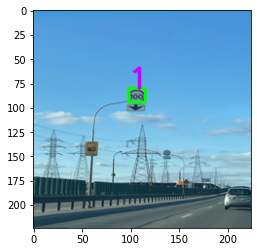

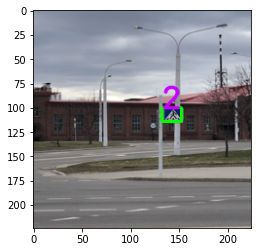

In [10]:
import matplotlib.patches as patches
def plot_image_withbbox(img, bboxs, labels=[], flag_bgr=1):
    imageplot=img.copy()
    if len(labels)==0:
        for bb in bboxs:
            cv2.rectangle(imageplot,(int(bb[0]),int(bb[1])),(int(bb[2]),int(bb[3])),(0,255,0),2)
    else:
        for bb, label in zip(bboxs,labels):
            cv2.rectangle(imageplot,(int(bb[0]),int(bb[1])),(int(bb[2]),int(bb[3])),(0,255,0),2)
            cv2.putText(imageplot, str(label), (int(bb[0]),int(bb[1])), 0, 1, (200, 0, 255), 2, cv2.LINE_AA)
    if flag_bgr==1:
        plt.imshow(cv2.cvtColor(imageplot, cv2.COLOR_BGR2RGB))
    else:
         plt.imshow(imageplot)
    plt.show()
    
def nms(bboxes, scores, threshold=0.5):
    # bboxes: boundary boxes, size: n_box*4 (x_min, y_min, x_max, y_max), pytorch tensor
    # score: confidence for each box, size: n_box, pytorch tensor 
    x1 = bboxes[:,0]
    y1 = bboxes[:,1]
    x2 = bboxes[:,2]
    y2 = bboxes[:,3]
    areas = (x2-x1)*(y2-y1)   # [n_box,] area for each box
    _, order = scores.sort(0, descending=True)    # sort
    keep = []
    while order.numel() > 0:       # torch.numel() order裡面的物件數
        if order.numel() == 1:     #保留框只剩下一個
            i = order.item()
            keep.append(i)
            break
        else:
            i = order[0].item()    # 保留scores最大的那個物件框box[i]
            keep.append(i)
        # 计算scores最大的那個物件框box[i] 與其他物件框的IOU (boardcast運算)
        xx1 = x1[order[1:]].clamp(min=x1[i])  
        yy1 = y1[order[1:]].clamp(min=y1[i])
        xx2 = x2[order[1:]].clamp(max=x2[i])
        yy2 = y2[order[1:]].clamp(max=y2[i])
        inter = (xx2-xx1).clamp(min=0) * (yy2-yy1).clamp(min=0)   

        iou = inter / (areas[i]+areas[order[1:]]-inter)  
        idx = (iou <= threshold).nonzero().squeeze()
        if idx.numel() == 0:
            break
        order = order[idx+1]  
    return torch.LongTensor(keep)   

def xyhw2box(box):
    wh = box[:,2:4] 
    xy = box[:,0:2] 
    xy_min = xy-wh/2
    xy_max = xy+wh/2
    box[:,0:2] = xy_min
    box[:,2:4] = xy_max
    box[box<0]=0
#     canad_bbox = np.array(canad_bbox, np.uint64) 
    return box 

# torch.cuda.empty_cache()
# use_cuda = 1
# device = torch.device("cuda:0" if use_cuda else "cpu")
# n_class = 4
# n_bbox = 3
# img_dim = 224

model = torch.load('yolov2_5.pth') 


mytransforms = transforms.Compose(
            [   transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ])    


  
image_paths =['./dataset/stopsign/images/road32.png',
              './dataset/stopsign/images/road69.png',
              './dataset/stopsign/images/road201.png',
             './dataset/stopsign/images/road12.png',
             './dataset/stopsign/images/road409.png',
             './dataset/stopsign/images/road187.png']


model.eval()
for image_path in image_paths:
    image = Image.open(image_path, mode='r')
    image = image.convert('RGB')
    image = image.resize((img_dim,img_dim))  # uint8 with RGB mode
    imageplot = np.array(image).copy()
    
    
    
    img = mytransforms(image)
    img = torch.unsqueeze(img,dim=0)
    img = img.to(device)   
    with torch.no_grad():
        out_16s, out_32s = model(img)
        pred_boxes_16s, pred_conf_16s, pred_cls_16s = yololayer16s(out_16s)
        pred_boxes_32s, pred_conf_32s, pred_cls_32s = yololayer32s(out_32s)
    
    canad_bbox = torch.cat([pred_boxes_16s, pred_boxes_32s],axis=1).detach().cpu()
    pred_conf = torch.cat([pred_conf_16s, pred_conf_32s],axis=1).detach().cpu()
    pred_cls = torch.cat([pred_cls_16s, pred_cls_32s],axis=1).detach().cpu()
    canad_bbox=canad_bbox[0,:]
    pred_conf=pred_conf[0,:].squeeze()
    pred_cls=pred_cls[0,:]
    pred_label = np.argmax(pred_cls,axis=1)
    
    

    
    pos = np.where(pred_conf>0.9)
    pred_conf  = pred_conf[pos[0]]
    canad_bbox = canad_bbox[pos[0],:]
    pred_label = pred_label[pos[0]]
    
    canad_bbox = xyhw2box(canad_bbox)

    pos_nms = nms(canad_bbox, pred_conf, threshold=0.1)
    
    canad_bbox = canad_bbox[pos_nms.numpy(),:]
    pred_label = pred_label[pos_nms.numpy()].numpy()
   
    
    plot_image_withbbox(imageplot, canad_bbox, pred_label, flag_bgr=0)


#     labelmap = {'trafficlight': 0, 'speedlimit': 1, 'crosswalk': 2, 'stop': 3}

